# Bayesian Hidden Markov Models

This tutorial illustrates training Bayesian Hidden Markov Models (HMM) using *Turing*. The main goals are learning the transition matrix, emission parameter, and hidden states.

Let's load the libraries we'll need. We also set a random seed (for reproducibility) and the automatic differentiation backend to forward mode (more [here](https://github.com/TuringLang/Turing.jl/issues/511) on why this is useful). 

In [1]:
# Load libraries.
using Turing, Plots, Random

# Set a random seed and use the forward_diff AD mode.
Random.seed!(1234);
Turing.setadbackend(:forward_diff);

## Simple State Detection

In this example, we'll use something where the states and emission parameters are very obvious. 

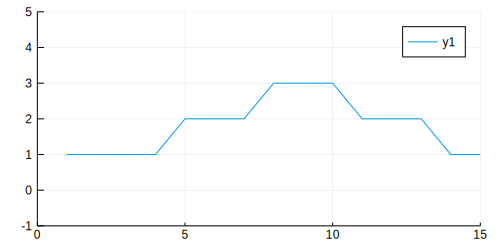

In [114]:
# Define the emission parameter.
y = [ 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0 ];
N = length(y);  K = 3;

# Plot the data we just made.
plot(y, xlim = (0,15), ylim = (-1,5), size = (500, 250))

We can see that we have three states, one for each height of the plot (1, 2, 3). This height is also our emission parameter, so state one produces a value of one, state two produces a value of two, and so on.

Ultimately, we would like to understand three major parameters:

1. The transition matrix. This is a matrix that assigns a probability of switching from one state to any other state, including the state that we are already in.
2. The emission matrix, which describes a typical value emitted by some state. In the plot above, the emission parameter for state one is simply one.
3. The state sequence is our understanding of what state we were actually in when we observed some data. This is very important in more sophisticated HMM models.

With this in mind, let's set up our model.

In [123]:
# Turing model definition.
@model BayesHmm(y) = begin
    # State sequence.
    s = tzeros(Int, N)
    
    # Emission matrix.
    m = Vector{Real}(undef, K)
    
    # Transition matrix.
    T = Vector{Vector{Real}}(undef, K)
    
    # Assign distributions to each element 
    # of the transition matrix and the
    # emission matrix.
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.5)
    end
    
    # Observe each point of the input.
    s[1] ~ Categorical(K)
    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
    return(s, m)
end;

We will use a combination of two samplers ([HMC](http://turing.ml/docs/library/#Turing.HMC) and [Particle Gibbs](http://turing.ml/docs/library/#Turing.PG)) by passing them to the [Gibbs](http://turing.ml/docs/library/#Turing.Gibbs) sampler. The Gibbs sampler allows for compositional inference, where we can pass samplers across different parameters. In this case, we use HMC for `m` and `T`, representing the emission and transition matrices respectively. We use the Particle Gibbs sampler for `s`, the state sequence.

In [129]:
g = Gibbs(1000, HMC(2, 0.001, 7, :m, :T), PG(20, 1, :s))
c = sample(BayesHmm(y), g);

┌ Info:  Assume - `T` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `m` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `s` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Observe - `y` is an observation
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:153
[Gibbs] Sampling...100% Time: 0:01:26
┌ Info: [Gibbs] Finished with
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:163
┌ Info:   Running time    = 85.85996221799995;
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:164


Let's see how well our chain performed. Ordinarily, using the `describe` function from [MCMCChain](https://github.com/TuringLang/MCMCChain.jl) would be a good first step, but we have generated a lot of parameters here. It's a bit easier to show how our model performed graphically.

The code below generates an animation showing the graph of the data above, and the data our model generates in each sample.

In [131]:
# Import StatsPlots for animating purposes.
using StatPlots

# Extract our m and s parameters from the chain.
m_set = c[:m]
s_set = c[:s]

# Iterate through the MCMC samples.
Ns = 1:300

# Make an animation.
animation = @animate for (i, N) in enumerate(Ns)
    m = m_set[N]; s = s_set[N];
    p = plot(y, c = :red,
        size = (500, 250), 
        xlabel = "Time", 
        ylabel = "State", 
        legend = legend = :topright, label = "True data",
        xlim = (0,15),
        ylim = (-1,5)); 
    plot!(p, m[s], c = :blue, label = "Sample $N")
end every 5;

┌ Info: Saved animation to 
│   fn = /home/cameron/code/TuringTutorials/tmp1.gif
└ @ Plots /home/cameron/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/home/cameron/code/TuringTutorials/tmp1.gif")

![animation](https://user-images.githubusercontent.com/422990/48961918-affd9b00-ef2d-11e8-9b7f-3bb39abd8662.gif)

Looks like our model did a pretty good job!

## Detecting A Fair Coin

Now it's all well and good to plot a line on a nice, clean dataset. But what if we are trying to detect when someone is cheating us in a coin flipping game? 

Let's say we have a friend named Jane. Every once in a while we play a game with Jane where she flips a coin. Jane wins a dollar from us if it's heads, we win a dollar from Jane if it's tails. The problem is that Jane is sometimes a cheater -- 20% of the time, she'll bring out a coin that comes up heads 90% of the time, and she decides to switch back to the fair coin 80% of the time so we don't become suspicious. Hidden Markov models are ideal for learning this kind of transition matrix, so let's get to it.

We set up some variables first, namely the transition matrix described in the preceding paragraph, and Bernoulli distributions for each of the coin flip types, fair and unfair.

In [382]:
# Define our fair/unfair coinflip probabilities.
p_heads_fair = 0.5
p_heads_unfair = 0.9

# Setup Bernoulli distributions for our coinflips.
# Note that we use 1 - p, because we
fair = Bernoulli(1 -p_heads_fair);
unfair = Bernoulli(1 - p_heads_unfair);

# Define our transition matrix.
transition_target = [0.9 0.1;
                     0.8 0.2];

The code below generates Jane's sometimes-unfair coinflips. 

In [383]:
# Number of coinflips we observe.
num_flips = 20

# Create variables to stash our coin flips and states.
flips = []
states = []

# Jane always starts with a fair coin. How nice.
fair_coin = true

# Generate our coin flips.
for i in 1:num_flips
    # This variable stores the probability of staying with
    # the current coin, fair or unfair.
    success_val = 0
    
    # Flip the relevant coin and get the success_val.
    if fair_coin == true
        push!(flips, rand(fair))
        success_val = transition_target[1,1]
    else
        push!(flips, rand(unfair))
        success_val = transition_target[2,2]
    end
    
    # Add the state we just used to the states variable.
    push!(states, fair_coin)
    
    # Calculate whether to stay in our current state.
    new_state = rand(Bernoulli(success_val))
    
    # If we got a zero in new_state, switch coins.
    if new_state == 0
        fair_coin = ~fair_coin
    end
end

Time to declare our Turing model. You will note that this model is very similar to the one we used in the previous example, but now the emission parameter `m` has a `Beta` prior. This will allow us to model the probability of getting a heads in each state. Additionally, when we observe each data point `y[i]`, we are using the `Bernoulli` distribution, which models this coin-flipping game better than the `Normal` dsitribution we used previously.

In [395]:
# Turing model definition.
@model BayesHmmCoins(y, K) = begin
    num_obs = length(y)
    
    # State sequence.
    s = tzeros(Int, num_obs)
    
    # Emission matrix.
    m = Vector{Real}(undef, K)
    
    # Transition matrix.
    T = Vector{Vector{Real}}(undef, K)
    
    # Assign distributions to each element 
    # of the transition matrix and the
    # emission matrix.
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Beta(1,1)
    end
    
    # Observe each point of the input.
    s[1] ~ Categorical(K)
    for i = 2:num_obs
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Bernoulli(m[s[i]])
    end
    
    return(s, m)
end;

We reuse the Gibbs sampler as declared above, but with some parameters changed around very slightly.

In [411]:
g = Gibbs(500, HMC(10, 0.001, 10, :m, :T), PG(60, 1, :s))
c2 = sample(BayesHmmCoins(flips, 2), g);

┌ Info:  Assume - `T` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `m` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `s` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Observe - `y` is an observation
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:153
[Gibbs] Sampling...100% Time: 0:01:44
┌ Info: [Gibbs] Finished with
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:163
┌ Info:   Running time    = 104.23629854699996;
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:164


What do each of the parameters in our HMM model (the transition matrix, emission matrix, or state sequence) tell us?

Jane has already cheated us in the past, so the state sequence matrix won't be very helpful on it's own in future games. The emission matrix tells us how probable a heads is in each state. The transition matrix can use it to determine the probabilities that Jane will cheat us in the future, assuming we know the current state.

The graph below plots the distance between the main diagonals on the transition matrix that Jane uses, and the ones we sampled from.

In [412]:
# Extract our m and s parameters from the chain.
t_set = c2[:T]

# Iterate through the MCMC samples.
Ns = 1:length(t_set)

# Make an animation.
animation = @animate for (i, N) in enumerate(Ns)
    t = t_set[N]
    point1 = (t[1][1], t[1][2])
    point2 = (transition_target[1, 1], transition_target[1, 2])
    p1_dist = abs(point1[1] - point2[1])
    
    point3 = (t[2][1], t[2][2])
    point4 = (transition_target[2, 1], transition_target[2, 2])
    p2_dist = abs(point3[2] - point4[2])
    
    bar([p1_dist, p2_dist], 
        title="Sample $N", 
        ylim=(0,0.2),
        labels = ["State 1", "State 2"])
end every 10;

gif(animation, "tmp.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /home/cameron/code/TuringTutorials/tmp.gif
└ @ Plots /home/cameron/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/home/cameron/code/TuringTutorials/tmp.gif")